<a href="https://colab.research.google.com/github/dxjzsyt/aiops_code/blob/main/arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

In [107]:
import os

import numpy as np 
import pandas as pd 
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import pmdarima as pm

In [108]:
csv_path='/content/drive/MyDrive/data/aiops_book/anomaly_detection/ad_data.csv'
time_series_df=pd.read_csv(csv_path)
time_series_df.head()

,timestamp,value
0,2014-04-10 00:04:00,91.958
1,2014-04-10 00:09:00,94.798
2,2014-04-10 00:14:00,92.208
3,2014-04-10 00:19:00,93.722
4,2014-04-10 00:24:00,93.042


In [15]:
time_series_df.load_date = pd.to_datetime(time_series_df.timestamp, format='%Y-%m-%d %H:%M:%S')
time_series_df = time_series_df.sort_values(by="timestamp")
time_series_df = time_series_df.reset_index(drop=True)
time_series_df.head()
# time_series_df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



,timestamp,value
0,2014-04-10 00:04:00,91.958
1,2014-04-10 00:09:00,94.798
2,2014-04-10 00:14:00,92.208
3,2014-04-10 00:19:00,93.722
4,2014-04-10 00:24:00,93.042


In [16]:
actual_vals = time_series_df.value.values
train, test = actual_vals[0:-70], actual_vals[-70:]
train_log, test_log = np.log10(train), np.log10(test)


In [17]:

stepwise_model = pm.auto_arima(train_log, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=11.51 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-16194.975, Time=0.35 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-17909.275, Time=2.78 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=8.77 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-16581.532, Time=0.25 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-18470.316, Time=4.84 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=13.87 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=7.21 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-18143.388, Time=1.98 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-18508.618, Time=3.82 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-18051.830, Time=4.60 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=12.60 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=8.14 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=-18527.206, Time=8.86 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=-1

predicted=1.977067, expected=1.982326
predicted=1.975898, expected=1.974088
predicted=1.976380, expected=1.967707
predicted=1.973712, expected=1.969071
predicted=1.977084, expected=1.974862
predicted=1.981791, expected=1.980576
predicted=1.970267, expected=1.971656
Test rmse: 0.008


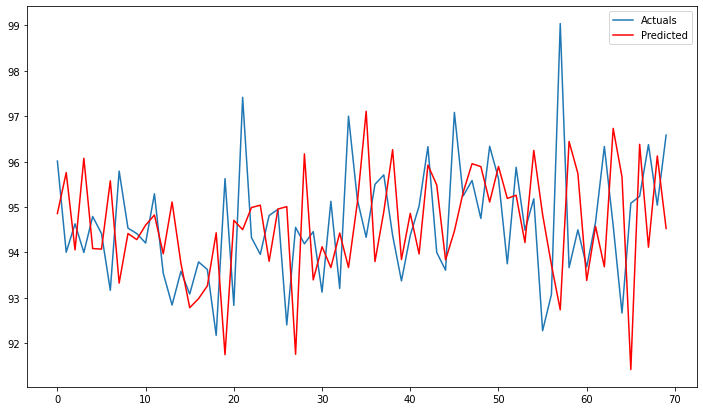

In [18]:

# split data into train and test-sets

history = [x for x in train_log]
predictions = list()
predict_log=list()
for t in range(len(test_log)):
    #model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    stepwise_model.fit(history)
    output = stepwise_model.predict(n_periods=1)
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)
    if(t%10==0):
      print('predicted=%f, expected=%f' % (output[0], obs))
error = math.sqrt(mean_squared_error(test_log, predict_log))
print('Test rmse: %.3f' % error)
# plot
figsize=(12, 7)
plt.figure(figsize=figsize)
pyplot.plot(test,label='Actuals')
pyplot.plot(predictions, color='red',label='Predicted')
pyplot.legend(loc='upper right')
pyplot.show()

In [86]:
predicted_df=pd.DataFrame()
predicted_df['timestamp']=time_series_df['timestamp'][-70:]
predicted_df['actuals']=test
predicted_df['predicted']=predictions
predicted_df.reset_index(inplace=True)
del predicted_df['index']
predicted_df.head()

,timestamp,actuals,predicted
0,2014-04-23 18:24:00,96.012,94.856497
1,2014-04-23 18:29:00,94.006,95.757690
2,2014-04-23 18:34:00,94.630,94.056677
3,2014-04-23 18:39:00,94.000,96.073375
4,2014-04-23 18:44:00,94.792,94.085766


In [112]:
def detect_anomalies(df,window):
  df.replace([np.inf, -np.inf], np.NaN, inplace=True)
  df.fillna(0,inplace=True)
  df['error']=df['actuals']-df['predicted']
  df['percentage_change'] = ((df['actuals'] - df['predicted']) / df['actuals']) * 100
  df['meanval'] = df['error'].rolling(window=window).mean()
  df['deviation'] = df['error'].rolling(window=window).std()
  df['-3s'] = df['meanval'] - (2 * df['deviation'])
  df['3s'] = df['meanval'] + (2 * df['deviation'])
  df['-2s'] = df['meanval'] - (1.75 * df['deviation'])
  df['2s'] = df['meanval'] + (1.75 * df['deviation'])
  df['-1s'] = df['meanval'] - (1.5 * df['deviation'])
  df['1s'] = df['meanval'] + (1.5 * df['deviation'])

  df['anomaly'] = 0
  df.loc[df['error'] > df['3s'], 'anomaly'] = 1
  df.loc[df['error'] < df['-3s'], 'anomaly'] = -1
  df.timestamp = pd.to_datetime(df.timestamp, format='%Y-%m-%d %H:%M:%S')
  df=df.sort_values(by="timestamp")
  df.dropna(inplace=True)
  return df

In [113]:
anomaly_df=detect_anomalies(predicted_df,7)
anomaly_df.head(10)

,timestamp,actuals,predicted,error,percentage_change,meanval,deviation,-3s,3s,-2s,2s,-1s,1s,anomaly
6,2014-04-23 18:54:00,93.166,95.577663,-2.411663,-2.588566,-0.494223,1.514008,-3.522238,2.533792,-3.143736,2.155290,-2.765234,1.776788,0
7,2014-04-23 18:59:00,95.792,93.324674,2.467326,2.575712,-0.306820,1.805392,-3.917604,3.303965,-3.466256,2.852617,-3.014908,2.401269,0
8,2014-04-23 19:04:00,94.536,94.416835,0.119165,0.126052,-0.039555,1.690683,-3.420920,3.341811,-2.998250,2.919140,-2.575579,2.496469,0
9,2014-04-23 19:09:00,94.416,94.283183,0.132817,0.140673,-0.102484,1.672165,-3.446815,3.241846,-3.028774,2.823805,-2.610732,2.405764,0
10,2014-04-23 19:14:00,94.208,94.601447,-0.393447,-0.417637,0.137505,1.447636,-2.757767,3.032778,-2.395858,2.670869,-2.033949,2.308960,0
11,2014-04-23 19:19:00,95.292,94.824464,0.467536,0.490635,0.103406,1.434761,-2.766116,2.972928,-2.407426,2.614238,-2.048736,2.255547,0
12,2014-04-23 19:24:00,93.542,93.971210,-0.429210,-0.458842,-0.006782,1.442968,-2.892719,2.879154,-2.531977,2.518412,-2.171235,2.157670,0
13,2014-04-23 19:29:00,92.842,95.111612,-2.269612,-2.444596,0.013511,1.403983,-2.794455,2.821477,-2.443460,2.470481,-2.092464,2.119485,0
14,2014-04-23 19:34:00,93.584,93.763629,-0.179629,-0.191944,-0.364626,0.898350,-2.161325,1.432074,-1.936738,1.207487,-1.712150,0.982899,0
15,2014-04-23 19:39:00,93.084,92.784027,0.299973,0.322260,-0.338796,0.916984,-2.172765,1.495173,-1.943519,1.265927,-1.714273,1.036681,0


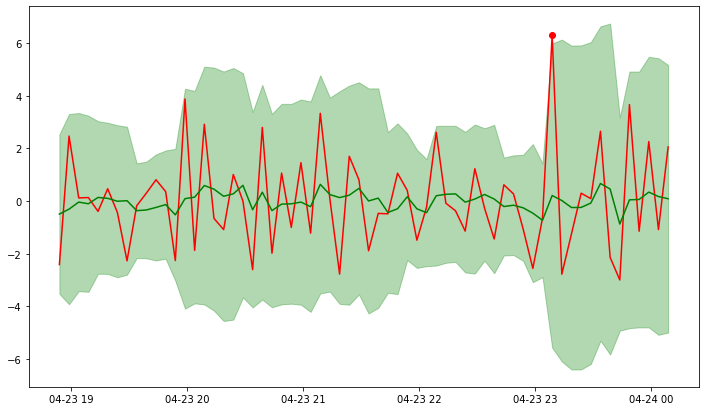

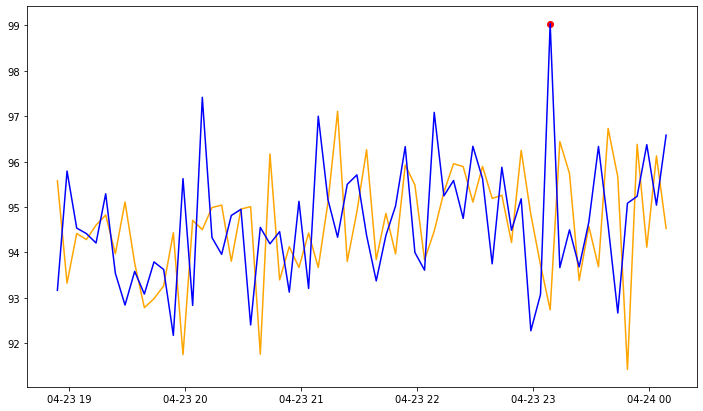

In [114]:
def plot_anomalies(df):
  figsize=(12, 7)
  plt.figure(figsize=figsize)
  # plt.scatter(pred['ds'],pred['fact'])
  # plt.scatter(pred.loc[pred['anomaly']!=0,'ds'],pred.loc[pred['anomaly']!=0,'fact'], c = 'red')
  plt.plot(df['timestamp'],df['error'],color="red")
  plt.plot(df['timestamp'],df['meanval'],color="green")
  plt.scatter(df.loc[df['anomaly']!=0,'timestamp'],df.loc[df['anomaly']!=0,'error'], c = 'red')
  plt.fill_between(df['timestamp'],df['-3s'],df['3s'],color='g',alpha=0.3)
  plt.show()

  figsize=(12, 7)a
  plt.figure(figsize=figsize)
  plt.plot(df['timestamp'],df['predicted'],color="orange")
  plt.scatter(df.loc[df['anomaly']!=0,'timestamp'],df.loc[df['anomaly']!=0,'actuals'], c = 'red')
  plt.plot(df['timestamp'],df['actuals'],color='blue')
  plt.show()
plot_anomalies(anomaly_df)